In [1]:
import os, numpy as np, collections

npz_dir = "D:/dataset/converted_classifier_npz_compact"
label_hist = collections.Counter()
shapes, dtypes, mins, maxs = [], set(), [], []

for f in os.listdir(npz_dir):
    if not f.endswith(".npz"): continue
    d = np.load(os.path.join(npz_dir,f), allow_pickle=True)
    imgs, labels = d["image"], d["label"]
    shapes.append(imgs.shape[1:3])
    dtypes.add(imgs.dtype)
    mins.append(imgs.min()); maxs.append(imgs.max())
    for v in labels: label_hist[int(v)] += 1

print("Unique shapes (H,W):", set(shapes))
print("Image dtypes:", dtypes)
print("Pixel value range across dataset:", min(mins), "-", max(maxs))
print("Label distribution:", dict(label_hist))


Unique shapes (H,W): {(281, 372)}
Image dtypes: {dtype('uint8')}
Pixel value range across dataset: 0 - 255
Label distribution: {0: 245380, 2: 4479, 1: 2141}


In [3]:
import os 
import numpy as np
from tqdm import tqdm

# -----------------------------
# Parameters
# -----------------------------
INPUT_DIR = "D:/dataset/converted_classifier_npz_compact"
OUTPUT_DIR = "D:/dataset/npz_80_tiny"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_FRAMES = 80  # total frames to save per case

print("Building reduced dataset with smart oversampling v2...")

rng = np.random.default_rng(seed=42)

for file in tqdm(sorted(os.listdir(INPUT_DIR))):
    if not file.endswith(".npz"):
        continue

    path = os.path.join(INPUT_DIR, file)
    case = np.load(path)

    images = case["image"]
    labels = case["label"]
    pixel_spacing = case["pixel_spacing"]
    ac_reference = case["ac_reference"]
    uuid = case["uuid"]

    has_mask = "mask" in case.files
    if has_mask:
        masks = case["mask"]

    # -----------------------------
    # Separate positive and negative frames
    # -----------------------------
    pos_idx = np.where(labels > 0)[0]
    neg_idx = np.where(labels == 0)[0]
    rng.shuffle(pos_idx)
    rng.shuffle(neg_idx)

    # -----------------------------
    # Oversampling logic
    # -----------------------------
    if len(pos_idx) == 0:
        chosen_idx = neg_idx[:TARGET_FRAMES]
    else:
        if len(pos_idx) < 10:
            pos_idx = np.tile(pos_idx, 4)  # oversample positives

        n_pos = len(pos_idx)
        n_neg = TARGET_FRAMES - n_pos

        if n_neg < 0:
            chosen_idx = pos_idx[:TARGET_FRAMES]
        else:
            if len(neg_idx) < n_neg:
                extra_neg = rng.choice(neg_idx, size=n_neg - len(neg_idx), replace=True)
                neg_idx = np.concatenate([neg_idx, extra_neg])
            chosen_idx = np.concatenate([pos_idx, neg_idx[:n_neg]])

    rng.shuffle(chosen_idx)

    # -----------------------------
    # Extract frames
    # -----------------------------
    images_new = images[chosen_idx]
    labels_new = labels[chosen_idx]
    if has_mask:
        masks_new = masks[chosen_idx]

    # -----------------------------
    # Save reduced npz
    # -----------------------------
    save_dict = dict(
        image=images_new,
        label=labels_new,
        pixel_spacing=pixel_spacing,
        ac_reference=ac_reference,
        uuid=uuid,
    )
    if has_mask:
        save_dict["mask"] = masks_new

    out_path = os.path.join(OUTPUT_DIR, file)
    np.savez_compressed(out_path, **save_dict)

    print(f"{file}: saved {len(chosen_idx)} frames "
          f"(positives={np.sum(labels_new > 0)}, negatives={np.sum(labels_new == 0)})")


Building reduced dataset with smart oversampling v2...


  0%|          | 1/300 [00:00<01:45,  2.84it/s]

0199616b-bdeb-4119-97a3-a5a3571bd641.npz: saved 80 frames (positives=19, negatives=61)


  1%|          | 2/300 [00:00<01:40,  2.96it/s]

02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1.npz: saved 80 frames (positives=20, negatives=60)


  1%|          | 3/300 [00:00<01:36,  3.07it/s]

02ee26a5-a665-4531-bec1-8bac83345a94.npz: saved 80 frames (positives=36, negatives=44)


  1%|▏         | 4/300 [00:01<01:35,  3.10it/s]

032b9024-3685-4a81-a62e-813d2da3d387.npz: saved 80 frames (positives=39, negatives=41)


  2%|▏         | 5/300 [00:01<01:34,  3.12it/s]

0428da3d-fef4-4c9b-96f2-5ffedaee82d0.npz: saved 80 frames (positives=15, negatives=65)


  2%|▏         | 6/300 [00:01<01:33,  3.15it/s]

046ed03e-4b35-4519-bb5f-cd4b0474a060.npz: saved 80 frames (positives=19, negatives=61)


  2%|▏         | 7/300 [00:02<01:33,  3.14it/s]

04a04f2e-840b-47f8-a907-abe7aeab3f41.npz: saved 80 frames (positives=33, negatives=47)


  3%|▎         | 8/300 [00:02<01:33,  3.13it/s]

04ef1176-7d54-4942-899d-f0fa69ad34bb.npz: saved 80 frames (positives=43, negatives=37)


  3%|▎         | 9/300 [00:02<01:34,  3.09it/s]

056764b4-7c0c-4452-832d-3d1cbb5a0464.npz: saved 80 frames (positives=28, negatives=52)


  3%|▎         | 10/300 [00:03<01:34,  3.07it/s]

05f72776-bf41-40ea-bdea-a7bcfa1eb9ba.npz: saved 80 frames (positives=32, negatives=48)


  4%|▎         | 11/300 [00:03<01:32,  3.12it/s]

0607eff0-2268-46b6-8fb8-16e40a521a42.npz: saved 80 frames (positives=17, negatives=63)


  4%|▍         | 12/300 [00:03<01:32,  3.11it/s]

0658cdf9-53bc-46a9-ae86-cc99a6fc5e77.npz: saved 80 frames (positives=28, negatives=52)


  4%|▍         | 13/300 [00:04<01:32,  3.12it/s]

0685cfaf-d585-40b3-a365-52f70f2536b6.npz: saved 80 frames (positives=12, negatives=68)


  5%|▍         | 14/300 [00:04<01:31,  3.13it/s]

069c0349-1e8d-42d0-afa1-69c7114a742f.npz: saved 80 frames (positives=38, negatives=42)


  5%|▌         | 15/300 [00:04<01:30,  3.13it/s]

071ee12c-a8a5-45fd-b191-fd5ec3b00766.npz: saved 80 frames (positives=36, negatives=44)


  5%|▌         | 16/300 [00:05<01:30,  3.14it/s]

09ddeecb-72e0-417a-85fd-77d397f6219d.npz: saved 80 frames (positives=47, negatives=33)


  6%|▌         | 17/300 [00:05<01:29,  3.17it/s]

0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06.npz: saved 80 frames (positives=35, negatives=45)


  6%|▌         | 18/300 [00:05<01:30,  3.11it/s]

0d7c4d8f-6e07-4f2b-aa76-8915ce15a38f.npz: saved 80 frames (positives=17, negatives=63)


  6%|▋         | 19/300 [00:06<01:30,  3.11it/s]

0e2631b6-ed14-4ce4-bc17-896590c406fd.npz: saved 80 frames (positives=44, negatives=36)


  7%|▋         | 20/300 [00:06<01:29,  3.13it/s]

0f32e98f-8257-4649-a8a2-3cccb2c1a2e5.npz: saved 80 frames (positives=23, negatives=57)


  7%|▋         | 21/300 [00:06<01:28,  3.14it/s]

1269a6c4-7f04-4927-9308-e4fd68883906.npz: saved 80 frames (positives=29, negatives=51)


  7%|▋         | 22/300 [00:07<01:27,  3.17it/s]

12941223-b27c-47f5-bcb0-7f7bfba18bba.npz: saved 80 frames (positives=36, negatives=44)


  8%|▊         | 23/300 [00:07<01:26,  3.19it/s]

136db39d-90e4-4702-aee7-dc5cd3169268.npz: saved 80 frames (positives=23, negatives=57)


  8%|▊         | 24/300 [00:07<01:27,  3.17it/s]

1613944c-ea48-4953-84e9-953b9d86f175.npz: saved 80 frames (positives=24, negatives=56)


  8%|▊         | 25/300 [00:08<01:28,  3.12it/s]

177786dd-a8f4-4d57-ac1b-13811480bd09.npz: saved 80 frames (positives=29, negatives=51)


  9%|▊         | 26/300 [00:08<01:27,  3.14it/s]

17b31515-75fb-41fc-8908-7c0264d21204.npz: saved 80 frames (positives=34, negatives=46)


  9%|▉         | 27/300 [00:08<01:25,  3.18it/s]

19202c0a-fade-4c7a-9878-e91d823963d6.npz: saved 80 frames (positives=24, negatives=56)


  9%|▉         | 28/300 [00:08<01:26,  3.14it/s]

1a998ef3-797f-4a17-9aa6-96cfb9af87c9.npz: saved 80 frames (positives=44, negatives=36)


 10%|▉         | 29/300 [00:09<01:26,  3.12it/s]

1af7894a-9f0a-41e8-9c10-a11c0341a93e.npz: saved 80 frames (positives=43, negatives=37)


 10%|█         | 30/300 [00:09<01:26,  3.11it/s]

1b250c39-7217-4921-838b-ed2681ebfef2.npz: saved 80 frames (positives=24, negatives=56)


 10%|█         | 31/300 [00:09<01:26,  3.11it/s]

1b3db504-c1fe-45f0-96dc-3cfb851d5bca.npz: saved 80 frames (positives=24, negatives=56)


 11%|█         | 32/300 [00:10<01:27,  3.07it/s]

1c1a1114-3e30-436b-b656-101e6050ea32.npz: saved 80 frames (positives=60, negatives=20)


 11%|█         | 33/300 [00:10<01:25,  3.13it/s]

1cd004a2-94fb-429a-9e14-fc950bbd8852.npz: saved 80 frames (positives=21, negatives=59)


 11%|█▏        | 34/300 [00:10<01:24,  3.13it/s]

1d25be5c-d4ba-48bf-afd4-a133581f8491.npz: saved 80 frames (positives=28, negatives=52)


 12%|█▏        | 35/300 [00:11<01:23,  3.18it/s]

1d479820-767b-4d0f-b6cf-12ec5d3a26e7.npz: saved 80 frames (positives=15, negatives=65)


 12%|█▏        | 36/300 [00:11<01:22,  3.20it/s]

1dab0e37-e5e4-41d4-b132-32103b385c78.npz: saved 80 frames (positives=31, negatives=49)


 12%|█▏        | 37/300 [00:11<01:23,  3.15it/s]

1dc4fda1-c351-4f4f-8df8-9bb35eb46062.npz: saved 80 frames (positives=25, negatives=55)


 13%|█▎        | 38/300 [00:12<01:23,  3.15it/s]

1dccf454-18df-4bfb-b7bf-92acbea3d8e1.npz: saved 80 frames (positives=22, negatives=58)


 13%|█▎        | 39/300 [00:12<01:22,  3.15it/s]

1e927a7e-90cd-475b-848d-6dc6368f42ca.npz: saved 80 frames (positives=12, negatives=68)


 13%|█▎        | 40/300 [00:12<01:21,  3.18it/s]

1f002210-be79-4c02-b948-7c27c5fd2f1e.npz: saved 80 frames (positives=8, negatives=72)


 14%|█▎        | 41/300 [00:13<01:23,  3.10it/s]

1ff3221d-43d3-4065-9393-347f2d0edac0.npz: saved 80 frames (positives=20, negatives=60)


 14%|█▍        | 42/300 [00:13<01:22,  3.11it/s]

20a2b2a1-c91e-4ee0-93b6-c0d8fe2212db.npz: saved 80 frames (positives=36, negatives=44)


 14%|█▍        | 43/300 [00:13<01:23,  3.06it/s]

21127c13-cd7f-456b-ad07-71531d1cb054.npz: saved 80 frames (positives=46, negatives=34)


 15%|█▍        | 44/300 [00:14<01:22,  3.09it/s]

21883c54-c2ac-4bc3-b557-aa6d41d51087.npz: saved 80 frames (positives=42, negatives=38)


 15%|█▌        | 45/300 [00:14<01:23,  3.07it/s]

21e6dac4-7606-4abb-9284-d5d9bd0d2b6e.npz: saved 80 frames (positives=24, negatives=56)


 15%|█▌        | 46/300 [00:14<01:22,  3.09it/s]

21ef25cf-842d-4adf-be9a-d07e2e259855.npz: saved 80 frames (positives=34, negatives=46)


 16%|█▌        | 47/300 [00:15<01:20,  3.13it/s]

229525cd-637a-4560-ad44-45b6f04a5d1f.npz: saved 80 frames (positives=46, negatives=34)


 16%|█▌        | 48/300 [00:15<01:21,  3.09it/s]

23d90415-7355-4677-83aa-a214f6b17c03.npz: saved 80 frames (positives=18, negatives=62)


 16%|█▋        | 49/300 [00:15<01:20,  3.12it/s]

245dbf25-055e-4dba-8dfb-18cb27b4a880.npz: saved 80 frames (positives=36, negatives=44)


 17%|█▋        | 50/300 [00:16<01:19,  3.13it/s]

246c5909-ac94-47b1-b343-cb358939e359.npz: saved 80 frames (positives=22, negatives=58)


 17%|█▋        | 51/300 [00:16<01:20,  3.10it/s]

2594b3cd-e3c2-482d-879b-642f9cdb339d.npz: saved 80 frames (positives=20, negatives=60)


 17%|█▋        | 52/300 [00:16<01:20,  3.07it/s]

2697b349-9abe-4ec3-bb42-96ea329418eb.npz: saved 80 frames (positives=45, negatives=35)


 18%|█▊        | 53/300 [00:16<01:19,  3.09it/s]

28c99f94-69b1-4e19-95de-2fc228c419cf.npz: saved 80 frames (positives=18, negatives=62)


 18%|█▊        | 54/300 [00:17<01:19,  3.10it/s]

2a2817fe-e4d8-4fe6-a530-7456c3648c01.npz: saved 80 frames (positives=25, negatives=55)


 18%|█▊        | 55/300 [00:17<01:19,  3.10it/s]

2b1767d0-ce44-4093-8713-9b9ca2823ec7.npz: saved 80 frames (positives=12, negatives=68)


 19%|█▊        | 56/300 [00:17<01:18,  3.11it/s]

2b832993-22e9-4393-a9fe-9296864495ea.npz: saved 80 frames (positives=37, negatives=43)


 19%|█▉        | 57/300 [00:18<01:17,  3.14it/s]

2c979adb-f7ee-4775-86d8-66ca4169884a.npz: saved 80 frames (positives=20, negatives=60)


 19%|█▉        | 58/300 [00:18<01:16,  3.18it/s]

2c9934e1-ec1a-49ea-b24f-ff62de1965d1.npz: saved 80 frames (positives=29, negatives=51)


 20%|█▉        | 59/300 [00:18<01:15,  3.17it/s]

2cf6450c-a57e-41a8-8918-74218df6e9bf.npz: saved 80 frames (positives=19, negatives=61)


 20%|██        | 60/300 [00:19<01:15,  3.18it/s]

2cf8bcb5-3570-474b-a7bc-d86d9c037e08.npz: saved 80 frames (positives=20, negatives=60)


 20%|██        | 61/300 [00:19<01:14,  3.22it/s]

2dccc77d-0963-4199-8501-04925b3de876.npz: saved 80 frames (positives=28, negatives=52)


 21%|██        | 62/300 [00:19<01:13,  3.23it/s]

2de0ce54-f9ef-49ec-b4b8-59f304656111.npz: saved 80 frames (positives=22, negatives=58)


 21%|██        | 63/300 [00:20<01:15,  3.16it/s]

2e99ee0e-506a-443b-8c16-e8a0619da2f7.npz: saved 80 frames (positives=36, negatives=44)


 21%|██▏       | 64/300 [00:20<01:15,  3.13it/s]

2fe70922-1d3a-4ce7-b8ad-55a0c07efe74.npz: saved 80 frames (positives=15, negatives=65)


 22%|██▏       | 65/300 [00:20<01:15,  3.11it/s]

300602fc-058e-456b-b872-8e9573428309.npz: saved 80 frames (positives=24, negatives=56)


 22%|██▏       | 66/300 [00:21<01:14,  3.16it/s]

30555893-2ac6-45c9-b404-8ca2d9f90b05.npz: saved 80 frames (positives=28, negatives=52)


 22%|██▏       | 67/300 [00:21<01:14,  3.13it/s]

30d9ee24-7603-46c5-9d05-7d8a6d6a292e.npz: saved 80 frames (positives=30, negatives=50)


 23%|██▎       | 68/300 [00:21<01:13,  3.15it/s]

33397b96-5fad-441e-9b64-ff3bd5d0b2f9.npz: saved 80 frames (positives=22, negatives=58)


 23%|██▎       | 69/300 [00:22<01:11,  3.21it/s]

339c3f53-eaa7-4660-a2bb-b9e1726cd079.npz: saved 80 frames (positives=10, negatives=70)


 23%|██▎       | 70/300 [00:22<01:12,  3.15it/s]

3479bfa3-6c07-462b-ab3d-409026598f0f.npz: saved 80 frames (positives=20, negatives=60)


 24%|██▎       | 71/300 [00:22<01:12,  3.16it/s]

356d0021-3560-421a-96f4-ecffd4eb6005.npz: saved 80 frames (positives=11, negatives=69)


 24%|██▍       | 72/300 [00:23<01:12,  3.15it/s]

36bcc878-7cf1-494c-a67d-7520145cdde2.npz: saved 80 frames (positives=20, negatives=60)


 24%|██▍       | 73/300 [00:23<01:12,  3.14it/s]

36d10668-e159-4c9d-811e-b066f4872bda.npz: saved 80 frames (positives=13, negatives=67)


 25%|██▍       | 74/300 [00:23<01:11,  3.17it/s]

379f256a-879c-4e1d-9b30-a0e9ee51e098.npz: saved 80 frames (positives=10, negatives=70)


 25%|██▌       | 75/300 [00:23<01:10,  3.19it/s]

3825d340-86df-41a7-b415-8c880818ca8e.npz: saved 80 frames (positives=16, negatives=64)


 25%|██▌       | 76/300 [00:24<01:10,  3.17it/s]

3b3218ac-3616-4aaf-b0ae-b7287803a298.npz: saved 80 frames (positives=42, negatives=38)


 26%|██▌       | 77/300 [00:24<01:11,  3.14it/s]

3bd64075-6e7e-463d-86e1-19071f04327c.npz: saved 80 frames (positives=24, negatives=56)


 26%|██▌       | 78/300 [00:24<01:10,  3.15it/s]

3d221d3e-749e-4b06-ac7a-762c3fc4c88a.npz: saved 80 frames (positives=16, negatives=64)


 26%|██▋       | 79/300 [00:25<01:10,  3.14it/s]

3d24bef2-3cfa-439f-b74f-6ae1e404ab06.npz: saved 80 frames (positives=36, negatives=44)


 27%|██▋       | 80/300 [00:25<01:09,  3.19it/s]

3d902e8c-626f-46b6-8942-243b3270d929.npz: saved 80 frames (positives=10, negatives=70)


 27%|██▋       | 81/300 [00:25<01:09,  3.15it/s]

3d9ebba3-0eff-4e57-8641-7099ba774574.npz: saved 80 frames (positives=44, negatives=36)


 27%|██▋       | 82/300 [00:26<01:09,  3.15it/s]

3daf4e87-136f-4644-9ec7-35d4de3650c9.npz: saved 80 frames (positives=12, negatives=68)


 28%|██▊       | 83/300 [00:26<01:08,  3.17it/s]

3e42e61f-a6ec-47ae-bbb7-e84b47170a5f.npz: saved 80 frames (positives=31, negatives=49)


 28%|██▊       | 84/300 [00:26<01:07,  3.18it/s]

40d97ff5-0d2f-4d9c-a6bc-8d07713a86c2.npz: saved 80 frames (positives=50, negatives=30)


 28%|██▊       | 85/300 [00:27<01:07,  3.20it/s]

42950f64-500a-46a8-9957-ea690a8292a4.npz: saved 80 frames (positives=13, negatives=67)


 29%|██▊       | 86/300 [00:27<01:07,  3.16it/s]

43ccd4c5-0644-402c-8220-d1c04cfc34ec.npz: saved 80 frames (positives=25, negatives=55)


 29%|██▉       | 87/300 [00:27<01:07,  3.17it/s]

43f564f8-6772-4341-9083-128fd6eed4c9.npz: saved 80 frames (positives=24, negatives=56)


 29%|██▉       | 88/300 [00:28<01:06,  3.19it/s]

4454a0d6-325b-442b-b07a-54f26b52c0b2.npz: saved 80 frames (positives=15, negatives=65)


 30%|██▉       | 89/300 [00:28<01:05,  3.21it/s]

44b70504-4e9e-4e02-b13f-6c33808dd7f9.npz: saved 80 frames (positives=18, negatives=62)


 30%|███       | 90/300 [00:28<01:06,  3.15it/s]

4670a2b3-cad0-4d23-afaa-e823438f6944.npz: saved 80 frames (positives=70, negatives=10)


 30%|███       | 91/300 [00:28<01:05,  3.19it/s]

47540baa-7ab8-425a-9e77-8005cb1c02f4.npz: saved 80 frames (positives=22, negatives=58)


 31%|███       | 92/300 [00:29<01:04,  3.20it/s]

477c0589-f74a-4ecf-8b22-a27776fcbffe.npz: saved 80 frames (positives=14, negatives=66)


 31%|███       | 93/300 [00:29<01:04,  3.22it/s]

484c03b0-441d-4966-b10e-06b31d84e55e.npz: saved 80 frames (positives=8, negatives=72)


 31%|███▏      | 94/300 [00:29<01:04,  3.21it/s]

489efa27-f374-4d48-a251-dd2e4d1b09aa.npz: saved 80 frames (positives=28, negatives=52)


 32%|███▏      | 95/300 [00:30<01:03,  3.21it/s]

4908826a-f3f0-4357-8c8e-8b3d8e6d48c4.npz: saved 80 frames (positives=19, negatives=61)


 32%|███▏      | 96/300 [00:30<01:03,  3.22it/s]

4abd109b-71ff-4403-95a9-9a7d3592bf5f.npz: saved 80 frames (positives=14, negatives=66)


 32%|███▏      | 97/300 [00:30<01:03,  3.19it/s]

4acfbc25-cf86-49c1-bb77-689f40db4d34.npz: saved 80 frames (positives=37, negatives=43)


 33%|███▎      | 98/300 [00:31<01:03,  3.19it/s]

4adc2ad8-f29d-41e3-9bf6-cc935057ff71.npz: saved 80 frames (positives=16, negatives=64)


 33%|███▎      | 99/300 [00:31<01:03,  3.15it/s]

4b6b2a4e-8ad8-4f29-ad47-dad67dfccb6c.npz: saved 80 frames (positives=42, negatives=38)


 33%|███▎      | 100/300 [00:31<01:02,  3.18it/s]

4bf11a9a-cb81-4dd4-91d4-5f6a59deb47d.npz: saved 80 frames (positives=28, negatives=52)


 34%|███▎      | 101/300 [00:32<01:02,  3.18it/s]

4d1f4689-55ad-4b3d-bc3f-c43e66e0b92d.npz: saved 80 frames (positives=21, negatives=59)


 34%|███▍      | 102/300 [00:32<01:03,  3.13it/s]

4d4db621-e017-4c4b-a23d-62ddfa40a5d8.npz: saved 80 frames (positives=33, negatives=47)


 34%|███▍      | 103/300 [00:32<01:03,  3.10it/s]

4eebb2cd-df34-4bbb-871d-f37ed26a0204.npz: saved 80 frames (positives=16, negatives=64)


 35%|███▍      | 104/300 [00:33<01:02,  3.12it/s]

4fc1cf8c-52cf-444d-a1fb-6b85c47694b2.npz: saved 80 frames (positives=28, negatives=52)


 35%|███▌      | 105/300 [00:33<01:02,  3.11it/s]

502bfdba-4bb0-4c68-bd25-a7d2d7b1124e.npz: saved 80 frames (positives=36, negatives=44)


 35%|███▌      | 106/300 [00:33<01:03,  3.07it/s]

50fb5627-fea3-4126-8082-a88aa5590b51.npz: saved 80 frames (positives=17, negatives=63)


 36%|███▌      | 107/300 [00:34<01:01,  3.13it/s]

53056b82-e84c-404a-8d3d-29c1d24d94c8.npz: saved 80 frames (positives=10, negatives=70)


 36%|███▌      | 108/300 [00:34<01:00,  3.17it/s]

5320a755-d8e5-403d-9769-6d9fe9b598df.npz: saved 80 frames (positives=16, negatives=64)


 36%|███▋      | 109/300 [00:34<01:00,  3.17it/s]

537243c9-0bbe-4295-aea0-4c29316e1efb.npz: saved 80 frames (positives=35, negatives=45)


 37%|███▋      | 110/300 [00:34<00:59,  3.17it/s]

540607e9-2186-4213-9290-b6bbd655c846.npz: saved 80 frames (positives=26, negatives=54)


 37%|███▋      | 111/300 [00:35<00:59,  3.15it/s]

54305199-c82c-4b90-b4a1-2b166ef7bab5.npz: saved 80 frames (positives=26, negatives=54)


 37%|███▋      | 112/300 [00:35<00:59,  3.16it/s]

5568cf99-11f7-4641-abd5-9579405c0eb3.npz: saved 80 frames (positives=12, negatives=68)


 38%|███▊      | 113/300 [00:35<01:00,  3.11it/s]

55eff0af-e8a1-4afa-965d-fff5a69e7399.npz: saved 80 frames (positives=17, negatives=63)


 38%|███▊      | 114/300 [00:36<00:59,  3.11it/s]

585178ca-483e-45fa-9c89-2dbd51ebb69e.npz: saved 80 frames (positives=20, negatives=60)


 38%|███▊      | 115/300 [00:36<00:59,  3.12it/s]

58e919b6-12d7-4c32-86b4-adca239e7a85.npz: saved 80 frames (positives=36, negatives=44)


 39%|███▊      | 116/300 [00:36<00:58,  3.15it/s]

5bdd3202-3eac-417c-856b-c642ee0aabdf.npz: saved 80 frames (positives=35, negatives=45)


 39%|███▉      | 117/300 [00:37<00:58,  3.11it/s]

5be4a966-5b05-473a-8118-9557c95dea4d.npz: saved 80 frames (positives=33, negatives=47)


 39%|███▉      | 118/300 [00:37<00:57,  3.14it/s]

5c46829f-7584-4ff9-9e76-7f72eb8ae78f.npz: saved 80 frames (positives=44, negatives=36)


 40%|███▉      | 119/300 [00:37<00:57,  3.15it/s]

5d0e2f3c-f494-48a7-942b-2c5942982aaf.npz: saved 80 frames (positives=15, negatives=65)


 40%|████      | 120/300 [00:38<00:56,  3.17it/s]

5d8f1a4a-dc8a-402a-b8ac-64773efbd299.npz: saved 80 frames (positives=13, negatives=67)


 40%|████      | 121/300 [00:38<00:55,  3.20it/s]

5e4e59bc-8445-47e5-80f3-bf6256ee6ce3.npz: saved 80 frames (positives=26, negatives=54)


 41%|████      | 122/300 [00:38<00:56,  3.17it/s]

5f3d6529-2de6-472b-88b6-7b9dfbf225a9.npz: saved 80 frames (positives=24, negatives=56)


 41%|████      | 123/300 [00:39<00:56,  3.16it/s]

5f901dfd-0f6c-46a4-9670-b519fb6041c8.npz: saved 80 frames (positives=16, negatives=64)


 41%|████▏     | 124/300 [00:39<00:55,  3.18it/s]

600e0d45-94fc-495d-9936-dbbc93d41686.npz: saved 80 frames (positives=28, negatives=52)


 42%|████▏     | 125/300 [00:39<00:54,  3.18it/s]

607623df-dcd8-46c0-8379-b19979761584.npz: saved 80 frames (positives=36, negatives=44)


 42%|████▏     | 126/300 [00:40<00:56,  3.08it/s]

622104f3-3bcb-47ba-be01-2f8fa2cd6aa8.npz: saved 80 frames (positives=35, negatives=45)


 42%|████▏     | 127/300 [00:40<00:56,  3.04it/s]

6379f8dd-b528-4a52-99ce-5d574936bc02.npz: saved 80 frames (positives=36, negatives=44)


 43%|████▎     | 128/300 [00:40<00:56,  3.07it/s]

63d1d72d-e6fc-46d9-912f-f3bd914f774d.npz: saved 80 frames (positives=37, negatives=43)


 43%|████▎     | 129/300 [00:41<00:56,  3.02it/s]

6468fdf3-f005-4cfe-a400-679b3b246a49.npz: saved 80 frames (positives=12, negatives=68)


 43%|████▎     | 130/300 [00:41<00:55,  3.05it/s]

650d7789-6c25-47d5-9d8a-5294ace2f8ac.npz: saved 80 frames (positives=28, negatives=52)


 44%|████▎     | 131/300 [00:41<00:55,  3.06it/s]

676c09f1-a666-4deb-877a-3ee06026523c.npz: saved 80 frames (positives=41, negatives=39)


 44%|████▍     | 132/300 [00:42<00:56,  2.99it/s]

67d1dc32-1791-4595-937a-c51d4372c15c.npz: saved 80 frames (positives=32, negatives=48)


 44%|████▍     | 133/300 [00:42<00:54,  3.04it/s]

685ebd4e-483d-4b2f-8e35-d05de68d0cd6.npz: saved 80 frames (positives=11, negatives=69)


 45%|████▍     | 134/300 [00:42<00:53,  3.11it/s]

6902b8ff-aa25-4dc7-892e-6ba6dabb3b0e.npz: saved 80 frames (positives=10, negatives=70)


 45%|████▌     | 135/300 [00:43<00:53,  3.09it/s]

691a31e0-2910-49e3-8a1c-4b624cae3469.npz: saved 80 frames (positives=28, negatives=52)


 45%|████▌     | 136/300 [00:43<00:54,  3.03it/s]

69bca9da-204a-4d93-bacc-12919b720018.npz: saved 80 frames (positives=27, negatives=53)


 46%|████▌     | 137/300 [00:43<00:53,  3.04it/s]

6a235c9a-8844-46e8-8cde-cddb36960dc5.npz: saved 80 frames (positives=28, negatives=52)


 46%|████▌     | 138/300 [00:44<00:53,  3.00it/s]

6c1a6959-d923-49fc-856e-8af6ff0f43e3.npz: saved 80 frames (positives=18, negatives=62)


 46%|████▋     | 139/300 [00:44<00:52,  3.07it/s]

6d3158f9-6328-4975-8d8f-c2aaf84182ec.npz: saved 80 frames (positives=30, negatives=50)


 47%|████▋     | 140/300 [00:44<00:51,  3.13it/s]

6ef0b571-c9e2-4ec4-855e-bfbae65daa08.npz: saved 80 frames (positives=24, negatives=56)


 47%|████▋     | 141/300 [00:44<00:50,  3.14it/s]

6f1930d7-49ca-4752-9d50-d26f7799dacc.npz: saved 80 frames (positives=27, negatives=53)


 47%|████▋     | 142/300 [00:45<00:51,  3.09it/s]

6f3af20f-895c-4209-88a1-81b4ec0dcca6.npz: saved 80 frames (positives=16, negatives=64)


 48%|████▊     | 143/300 [00:45<00:51,  3.05it/s]

6fcb175f-52e4-4f3e-9956-f693b28f56e6.npz: saved 80 frames (positives=36, negatives=44)


 48%|████▊     | 144/300 [00:46<00:51,  3.02it/s]

70121050-3950-4eb1-ba24-efe37e9878e9.npz: saved 80 frames (positives=56, negatives=24)


 48%|████▊     | 145/300 [00:46<00:51,  3.02it/s]

7112c87c-fd2b-488e-bad7-f447f6b49caa.npz: saved 80 frames (positives=39, negatives=41)


 49%|████▊     | 146/300 [00:46<00:50,  3.07it/s]

716640b1-bf3c-4cf5-8e2f-1e81152b6323.npz: saved 80 frames (positives=35, negatives=45)


 49%|████▉     | 147/300 [00:46<00:50,  3.02it/s]

71a82fd5-e8f8-4338-bfcb-e45cdf54d885.npz: saved 80 frames (positives=30, negatives=50)


 49%|████▉     | 148/300 [00:47<00:50,  3.01it/s]

72ffb0d0-13ce-456a-bb77-e34ad244f1b2.npz: saved 80 frames (positives=22, negatives=58)


 50%|████▉     | 149/300 [00:47<00:49,  3.04it/s]

738785d4-987a-415e-97b2-efd9c5618c67.npz: saved 80 frames (positives=28, negatives=52)


 50%|█████     | 150/300 [00:47<00:49,  3.03it/s]

740e57a6-d368-48d2-a3ec-fae51776757b.npz: saved 80 frames (positives=20, negatives=60)


 50%|█████     | 151/300 [00:48<00:49,  3.01it/s]

74ddc9b8-9449-4cfa-8648-2131ecf9fd4a.npz: saved 80 frames (positives=12, negatives=68)


 51%|█████     | 152/300 [00:48<00:49,  3.01it/s]

7603739a-a716-4785-bca1-db034fdfdb54.npz: saved 80 frames (positives=76, negatives=4)


 51%|█████     | 153/300 [00:48<00:48,  3.00it/s]

762a51e8-d1b6-4b8e-b1e4-8080b83392d5.npz: saved 80 frames (positives=35, negatives=45)


 51%|█████▏    | 154/300 [00:49<00:48,  3.00it/s]

775c0509-c874-4eca-8426-055db54f457e.npz: saved 80 frames (positives=28, negatives=52)


 52%|█████▏    | 155/300 [00:49<00:48,  3.01it/s]

776b10a9-baa8-4c61-b096-bf8755b062e9.npz: saved 80 frames (positives=11, negatives=69)


 52%|█████▏    | 156/300 [00:49<00:46,  3.09it/s]

77b1166e-01d9-4b54-8793-288df6241e77.npz: saved 80 frames (positives=30, negatives=50)


 52%|█████▏    | 157/300 [00:50<00:45,  3.11it/s]

793bcf72-bcac-4d42-a726-66316996a6c5.npz: saved 80 frames (positives=12, negatives=68)


 53%|█████▎    | 158/300 [00:50<00:46,  3.06it/s]

7b06f498-6552-4d51-bf8a-11bb23b70a92.npz: saved 80 frames (positives=17, negatives=63)


 53%|█████▎    | 159/300 [00:50<00:46,  3.04it/s]

7b76359b-5d35-4b2b-868f-0988cce51784.npz: saved 80 frames (positives=73, negatives=7)


 53%|█████▎    | 160/300 [00:51<00:46,  3.02it/s]

7c7841fd-050e-4c32-8312-acad5968c6d7.npz: saved 80 frames (positives=18, negatives=62)


 54%|█████▎    | 161/300 [00:51<00:45,  3.05it/s]

7c98b80e-5a64-4973-9c2e-db2ee4b14736.npz: saved 80 frames (positives=27, negatives=53)


 54%|█████▍    | 162/300 [00:51<00:45,  3.07it/s]

7ce39b64-ca3f-4668-84b8-20ece5f4cc65.npz: saved 80 frames (positives=66, negatives=14)


 54%|█████▍    | 163/300 [00:52<00:45,  3.02it/s]

7d44ea4e-9079-4a4f-bd0e-2e27ff70e9ea.npz: saved 80 frames (positives=20, negatives=60)


 55%|█████▍    | 164/300 [00:52<00:45,  3.00it/s]

7ee50b1f-a484-4ee1-8990-178a3b227369.npz: saved 80 frames (positives=31, negatives=49)


 55%|█████▌    | 165/300 [00:52<00:44,  3.01it/s]

7f689365-1782-4e41-b357-951d68cd3eee.npz: saved 80 frames (positives=10, negatives=70)


 55%|█████▌    | 166/300 [00:53<00:43,  3.06it/s]

7f9d11c1-349b-4304-a672-4ed3f532d2f0.npz: saved 80 frames (positives=17, negatives=63)


 56%|█████▌    | 167/300 [00:53<00:43,  3.04it/s]

80bf8d64-ce5a-4c73-90b8-fe3261635be0.npz: saved 80 frames (positives=16, negatives=64)


 56%|█████▌    | 168/300 [00:53<00:43,  3.06it/s]

80fc531d-7187-4164-8798-b40ea16a2d2c.npz: saved 80 frames (positives=15, negatives=65)


 56%|█████▋    | 169/300 [00:54<00:43,  3.00it/s]

81c96ebf-d425-4756-9919-1845ef0d88a5.npz: saved 80 frames (positives=19, negatives=61)


 57%|█████▋    | 170/300 [00:54<00:43,  3.00it/s]

82fe659c-d3cd-4f0b-a171-a3947209662b.npz: saved 80 frames (positives=12, negatives=68)


 57%|█████▋    | 171/300 [00:54<00:42,  3.03it/s]

833c09d1-7257-45fc-9d41-76060614481f.npz: saved 80 frames (positives=24, negatives=56)


 57%|█████▋    | 172/300 [00:55<00:41,  3.07it/s]

84cf6a52-fe8a-4cce-bcae-717f500c11c0.npz: saved 80 frames (positives=28, negatives=52)


 58%|█████▊    | 173/300 [00:55<00:41,  3.08it/s]

856cbf9c-8eb7-459c-b9e7-641459b393b0.npz: saved 80 frames (positives=20, negatives=60)


 58%|█████▊    | 174/300 [00:55<00:40,  3.08it/s]

85a90b54-9536-45ac-ac62-ced5f1a6f72d.npz: saved 80 frames (positives=28, negatives=52)


 58%|█████▊    | 175/300 [00:56<00:40,  3.07it/s]

88224d16-3e42-4f10-9883-dbe1efeb6ae6.npz: saved 80 frames (positives=19, negatives=61)


 59%|█████▊    | 176/300 [00:56<00:40,  3.09it/s]

883501fc-2fcd-4fb4-b693-4d76df8a2ba4.npz: saved 80 frames (positives=49, negatives=31)


 59%|█████▉    | 177/300 [00:56<00:39,  3.14it/s]

89c3a8c0-1efe-4a7e-b921-c12f052cb2c0.npz: saved 80 frames (positives=32, negatives=48)


 59%|█████▉    | 178/300 [00:57<00:39,  3.10it/s]

8b80d5f7-3623-455a-8f37-7b92e6929bbb.npz: saved 80 frames (positives=12, negatives=68)


 60%|█████▉    | 179/300 [00:57<00:38,  3.12it/s]

8ba63007-395c-4f8b-b5a0-a5f17596588a.npz: saved 80 frames (positives=23, negatives=57)


 60%|██████    | 180/300 [00:57<00:39,  3.07it/s]

8ce68989-8856-4c3f-8988-4c9680b9a246.npz: saved 80 frames (positives=28, negatives=52)


 60%|██████    | 181/300 [00:58<00:39,  3.00it/s]

8daf5ef8-4a77-47dd-b1d8-d45caf83b64a.npz: saved 80 frames (positives=18, negatives=62)


 61%|██████    | 182/300 [00:58<00:38,  3.04it/s]

8ec339fb-b01a-4034-9e39-feef178be78d.npz: saved 80 frames (positives=20, negatives=60)


 61%|██████    | 183/300 [00:58<00:38,  3.02it/s]

8f50de4c-c82f-4210-8ba0-8edfe07fa017.npz: saved 80 frames (positives=32, negatives=48)


 61%|██████▏   | 184/300 [00:59<00:37,  3.05it/s]

90056737-5c36-4880-b11a-3b8d4bd84867.npz: saved 80 frames (positives=38, negatives=42)


 62%|██████▏   | 185/300 [00:59<00:38,  2.99it/s]

9062cf40-611e-4768-af8f-a6943d773afe.npz: saved 80 frames (positives=13, negatives=67)


 62%|██████▏   | 186/300 [00:59<00:37,  3.06it/s]

924c5f09-2a22-4286-b478-c3e466f59425.npz: saved 80 frames (positives=18, negatives=62)


 62%|██████▏   | 187/300 [01:00<00:37,  3.02it/s]

9323ce9c-6523-428e-93a9-894f2203f1f0.npz: saved 80 frames (positives=50, negatives=30)


 63%|██████▎   | 188/300 [01:00<00:37,  3.01it/s]

93454ca6-86b9-4c7c-ae26-88c440bb056a.npz: saved 80 frames (positives=32, negatives=48)


 63%|██████▎   | 189/300 [01:00<00:36,  3.03it/s]

938dda7a-321d-4ccc-ae3c-9276fe8a0e53.npz: saved 80 frames (positives=21, negatives=59)


 63%|██████▎   | 190/300 [01:01<00:37,  2.97it/s]

94e39208-2b04-4a1e-8f16-a830fc0fbaf1.npz: saved 80 frames (positives=16, negatives=64)


 64%|██████▎   | 191/300 [01:01<00:36,  3.00it/s]

95da2e16-5b4f-49cf-8c0f-86e3b7dff568.npz: saved 80 frames (positives=16, negatives=64)


 64%|██████▍   | 192/300 [01:01<00:35,  3.03it/s]

970b5275-ac9c-4844-abf5-d291becaf186.npz: saved 80 frames (positives=31, negatives=49)


 64%|██████▍   | 193/300 [01:02<00:34,  3.07it/s]

97363a66-8aec-4b52-8797-514e8c98205b.npz: saved 80 frames (positives=64, negatives=16)


 65%|██████▍   | 194/300 [01:02<00:34,  3.05it/s]

97bec430-f17c-47bc-a138-a9bd69f3875a.npz: saved 80 frames (positives=15, negatives=65)


 65%|██████▌   | 195/300 [01:02<00:34,  3.09it/s]

97cac2e6-4c2b-4a39-a602-0b01fa3ebc4c.npz: saved 80 frames (positives=12, negatives=68)


 65%|██████▌   | 196/300 [01:03<00:33,  3.12it/s]

98b74af5-0f1c-4e9d-ad98-3161c3c51bf0.npz: saved 80 frames (positives=13, negatives=67)


 66%|██████▌   | 197/300 [01:03<00:33,  3.07it/s]

9963dd36-4aaf-4342-bd8d-b67be6c5abf3.npz: saved 80 frames (positives=19, negatives=61)


 66%|██████▌   | 198/300 [01:03<00:32,  3.12it/s]

9add3d46-c8a2-4e4c-9f2a-98004647e8d5.npz: saved 80 frames (positives=34, negatives=46)


 66%|██████▋   | 199/300 [01:04<00:32,  3.14it/s]

9b42608f-5e7a-421f-881c-fa48ae65e146.npz: saved 80 frames (positives=17, negatives=63)


 67%|██████▋   | 200/300 [01:04<00:31,  3.13it/s]

9b7bab9e-b094-44f1-98dd-bf314bbbd7b4.npz: saved 80 frames (positives=55, negatives=25)


 67%|██████▋   | 201/300 [01:04<00:31,  3.15it/s]

9badcfbd-937a-4614-bbce-2b74f176b805.npz: saved 80 frames (positives=49, negatives=31)


 67%|██████▋   | 202/300 [01:04<00:30,  3.17it/s]

9c013b59-e6a0-49d9-9053-d359301acc9d.npz: saved 80 frames (positives=20, negatives=60)


 68%|██████▊   | 203/300 [01:05<00:30,  3.17it/s]

9cefbd53-b566-4757-90b2-cd36f487b1a3.npz: saved 80 frames (positives=14, negatives=66)


 68%|██████▊   | 204/300 [01:05<00:30,  3.19it/s]

9d80d91b-0514-4c2b-82ba-d1525f63fb1b.npz: saved 80 frames (positives=10, negatives=70)


 68%|██████▊   | 205/300 [01:05<00:29,  3.19it/s]

9d8768bf-02f0-4617-8997-f518983870ba.npz: saved 80 frames (positives=24, negatives=56)


 69%|██████▊   | 206/300 [01:06<00:29,  3.14it/s]

9ebb18b6-1f89-4f39-b380-3324d061d642.npz: saved 80 frames (positives=11, negatives=69)


 69%|██████▉   | 207/300 [01:06<00:29,  3.14it/s]

a2648805-a897-453b-a512-036c744843ec.npz: saved 80 frames (positives=11, negatives=69)


 69%|██████▉   | 208/300 [01:06<00:28,  3.19it/s]

a26af2dc-5455-44b5-8f30-ab4d25c3d518.npz: saved 80 frames (positives=17, negatives=63)


 70%|██████▉   | 209/300 [01:07<00:28,  3.22it/s]

a33cbbc6-6053-4378-874c-9db6d14bfee0.npz: saved 80 frames (positives=11, negatives=69)


 70%|███████   | 210/300 [01:07<00:27,  3.23it/s]

a42fef23-dd06-45ba-84f7-ab8d5b8216d8.npz: saved 80 frames (positives=18, negatives=62)


 70%|███████   | 211/300 [01:07<00:28,  3.18it/s]

a5c63b85-28f2-430d-8e44-dfaeee4aaa8b.npz: saved 80 frames (positives=15, negatives=65)


 71%|███████   | 212/300 [01:08<00:28,  3.13it/s]

a6c627d3-3776-4bb9-8d61-2c8261bdf295.npz: saved 80 frames (positives=36, negatives=44)


 71%|███████   | 213/300 [01:08<00:27,  3.16it/s]

a78a01b0-bb9b-4189-8eba-85a5f55d341f.npz: saved 80 frames (positives=10, negatives=70)


 71%|███████▏  | 214/300 [01:08<00:27,  3.16it/s]

a94b5a1e-a67f-45b0-9a51-8a7a0ca4d112.npz: saved 80 frames (positives=65, negatives=15)


 72%|███████▏  | 215/300 [01:09<00:26,  3.18it/s]

aa609674-742e-4bd3-9b07-fb501abeba3b.npz: saved 80 frames (positives=36, negatives=44)


 72%|███████▏  | 216/300 [01:09<00:26,  3.21it/s]

ab71c2e2-c1aa-49e1-aae2-f2aa649ff9a1.npz: saved 80 frames (positives=25, negatives=55)


 72%|███████▏  | 217/300 [01:09<00:25,  3.22it/s]

abb19883-26c3-46cd-96be-8c521827a2dd.npz: saved 80 frames (positives=19, negatives=61)


 73%|███████▎  | 218/300 [01:09<00:25,  3.24it/s]

acac6afb-e374-47a7-8954-d4ed87dd55df.npz: saved 80 frames (positives=11, negatives=69)


 73%|███████▎  | 219/300 [01:10<00:24,  3.25it/s]

acf89c93-b448-4d21-89c4-4b9d2b70b388.npz: saved 80 frames (positives=10, negatives=70)


 73%|███████▎  | 220/300 [01:10<00:24,  3.23it/s]

ad36de5e-42a1-4450-8364-bcef7234f9b6.npz: saved 80 frames (positives=15, negatives=65)


 74%|███████▎  | 221/300 [01:10<00:24,  3.19it/s]

ae58606d-8adf-4552-b42e-c251f446485e.npz: saved 80 frames (positives=68, negatives=12)


 74%|███████▍  | 222/300 [01:11<00:24,  3.14it/s]

ae6eed2f-58ca-47c2-a25d-c0d6ed80e178.npz: saved 80 frames (positives=20, negatives=60)


 74%|███████▍  | 223/300 [01:11<00:24,  3.11it/s]

af8fa0cf-5f02-47f5-b8dd-d215b049f264.npz: saved 80 frames (positives=23, negatives=57)


 75%|███████▍  | 224/300 [01:11<00:24,  3.12it/s]

b0a1773a-c44c-443b-8309-9ccac79416af.npz: saved 80 frames (positives=38, negatives=42)


 75%|███████▌  | 225/300 [01:12<00:24,  3.12it/s]

b1745834-4159-4d8b-959f-018dd56c2936.npz: saved 80 frames (positives=16, negatives=64)


 75%|███████▌  | 226/300 [01:12<00:23,  3.14it/s]

b3648eb1-83f3-45de-967b-040262574976.npz: saved 80 frames (positives=36, negatives=44)


 76%|███████▌  | 227/300 [01:12<00:23,  3.15it/s]

b3ea614a-32df-4965-af25-020c27f0ef74.npz: saved 80 frames (positives=13, negatives=67)


 76%|███████▌  | 228/300 [01:13<00:22,  3.20it/s]

b4482878-52b1-4339-bb97-fad3efe826aa.npz: saved 80 frames (positives=15, negatives=65)


 76%|███████▋  | 229/300 [01:13<00:22,  3.18it/s]

b48630a1-6dd5-4961-82f4-9eabb90f5db2.npz: saved 80 frames (positives=47, negatives=33)


 77%|███████▋  | 230/300 [01:13<00:21,  3.19it/s]

b5bdfc3d-2b3d-4590-b77e-53d41ecc14de.npz: saved 80 frames (positives=21, negatives=59)


 77%|███████▋  | 231/300 [01:14<00:21,  3.18it/s]

b711f9d5-bf79-493f-91ab-e16b7b1cf649.npz: saved 80 frames (positives=13, negatives=67)


 77%|███████▋  | 232/300 [01:14<00:21,  3.18it/s]

b81b9346-db70-4eff-aa7b-e36539d5ec43.npz: saved 80 frames (positives=16, negatives=64)


 78%|███████▊  | 233/300 [01:14<00:21,  3.17it/s]

b9b6d571-6bc3-4cc3-9ecc-97b4b1a58682.npz: saved 80 frames (positives=33, negatives=47)


 78%|███████▊  | 234/300 [01:15<00:20,  3.18it/s]

b9ef9a65-ab93-4714-a9e0-6df70ac8c285.npz: saved 80 frames (positives=14, negatives=66)


 78%|███████▊  | 235/300 [01:15<00:20,  3.19it/s]

ba245b67-f202-44d7-bab4-a07e214d7f81.npz: saved 80 frames (positives=30, negatives=50)


 79%|███████▊  | 236/300 [01:15<00:19,  3.21it/s]

ba6acb2e-8a8f-4a21-a986-ee1c2a1d41fc.npz: saved 80 frames (positives=24, negatives=56)


 79%|███████▉  | 237/300 [01:15<00:19,  3.22it/s]

baca1605-d47a-4ce9-bdfe-dc532e3c9a72.npz: saved 80 frames (positives=15, negatives=65)


 79%|███████▉  | 238/300 [01:16<00:19,  3.23it/s]

bd55bc61-5335-41af-920b-f66206c47502.npz: saved 80 frames (positives=24, negatives=56)


 80%|███████▉  | 239/300 [01:16<00:19,  3.14it/s]

bdd91da7-1f8e-4777-8142-e12c572e0945.npz: saved 80 frames (positives=36, negatives=44)


 80%|████████  | 240/300 [01:16<00:19,  3.12it/s]

bfd442e7-9299-4890-ad3d-c9d5b6534cbc.npz: saved 80 frames (positives=11, negatives=69)


 80%|████████  | 241/300 [01:17<00:18,  3.13it/s]

c0319132-d83e-4e3a-ad50-4b281f2dcebc.npz: saved 80 frames (positives=28, negatives=52)


 81%|████████  | 242/300 [01:17<00:18,  3.15it/s]

c04b58fd-bb95-4e4f-ab23-f8fea59b24bf.npz: saved 80 frames (positives=25, negatives=55)


 81%|████████  | 243/300 [01:17<00:17,  3.17it/s]

c13a9a64-6ca0-4d17-b49e-40ee01a45c3e.npz: saved 80 frames (positives=17, negatives=63)


 81%|████████▏ | 244/300 [01:18<00:17,  3.19it/s]

c2527ba6-5e4b-4efc-ab99-ecc4f833af86.npz: saved 80 frames (positives=19, negatives=61)


 82%|████████▏ | 245/300 [01:18<00:17,  3.17it/s]

c4ea83c8-62a9-40d4-bff3-52fe8cd60339.npz: saved 80 frames (positives=16, negatives=64)


 82%|████████▏ | 246/300 [01:18<00:16,  3.24it/s]

c9a235e5-f070-4b9f-afb9-149067423cd5.npz: saved 80 frames (positives=19, negatives=61)


 82%|████████▏ | 247/300 [01:19<00:16,  3.23it/s]

ca3db03c-02f8-4648-a0d0-5cf5cae8dbbf.npz: saved 80 frames (positives=10, negatives=70)


 83%|████████▎ | 248/300 [01:19<00:16,  3.17it/s]

cde42d64-d8ac-4d8e-966f-12be944535d0.npz: saved 80 frames (positives=36, negatives=44)


 83%|████████▎ | 249/300 [01:19<00:16,  3.16it/s]

cdedbdd3-d8b7-4384-ae4b-cb4eda575447.npz: saved 80 frames (positives=8, negatives=72)


 83%|████████▎ | 250/300 [01:20<00:15,  3.15it/s]

ce717c57-f72b-4759-8e26-12bd20464124.npz: saved 80 frames (positives=29, negatives=51)


 84%|████████▎ | 251/300 [01:20<00:15,  3.18it/s]

ced55401-e5ba-4da3-b24f-57b711f604bf.npz: saved 80 frames (positives=24, negatives=56)


 84%|████████▍ | 252/300 [01:20<00:14,  3.22it/s]

cf4c491d-62cf-4393-a4f1-db38e328d86e.npz: saved 80 frames (positives=19, negatives=61)


 84%|████████▍ | 253/300 [01:21<00:14,  3.18it/s]

d0da2318-e4de-4cb5-a575-cc5fd64449fa.npz: saved 80 frames (positives=32, negatives=48)


 85%|████████▍ | 254/300 [01:21<00:14,  3.20it/s]

d15a282b-25ca-40ab-915c-215335a0d3cf.npz: saved 80 frames (positives=32, negatives=48)


 85%|████████▌ | 255/300 [01:21<00:14,  3.19it/s]

d234b2ec-e6e7-4336-93cd-288314639995.npz: saved 80 frames (positives=26, negatives=54)


 85%|████████▌ | 256/300 [01:21<00:13,  3.19it/s]

d42fb920-5df1-4341-93df-480c17355e44.npz: saved 80 frames (positives=32, negatives=48)


 86%|████████▌ | 257/300 [01:22<00:13,  3.24it/s]

d5471cfd-6090-4d42-9a95-67ccbfbf612e.npz: saved 80 frames (positives=14, negatives=66)


 86%|████████▌ | 258/300 [01:22<00:13,  3.20it/s]

d571d4e1-ff80-44b9-a481-07961c6a1208.npz: saved 80 frames (positives=36, negatives=44)


 86%|████████▋ | 259/300 [01:22<00:12,  3.21it/s]

d5c3cfee-53ac-4021-8c1b-098c189f630e.npz: saved 80 frames (positives=40, negatives=40)


 87%|████████▋ | 260/300 [01:23<00:12,  3.19it/s]

d5f8c859-de93-4a50-b324-1ae4ad0267d4.npz: saved 80 frames (positives=32, negatives=48)


 87%|████████▋ | 261/300 [01:23<00:12,  3.17it/s]

d624338f-d09b-4bda-bbc3-3fa417015d6b.npz: saved 80 frames (positives=35, negatives=45)


 87%|████████▋ | 262/300 [01:23<00:11,  3.19it/s]

d77b6ece-da17-4f88-818c-0c7340b3e54f.npz: saved 80 frames (positives=33, negatives=47)


 88%|████████▊ | 263/300 [01:24<00:11,  3.22it/s]

d812091a-3635-4d51-9290-6adb3aa8681e.npz: saved 80 frames (positives=11, negatives=69)


 88%|████████▊ | 264/300 [01:24<00:11,  3.21it/s]

d8c3665a-4dc3-40ce-b716-f30aab365332.npz: saved 80 frames (positives=28, negatives=52)


 88%|████████▊ | 265/300 [01:24<00:10,  3.23it/s]

db9d468d-cb20-4d5e-b059-31728f5950e6.npz: saved 80 frames (positives=25, negatives=55)


 89%|████████▊ | 266/300 [01:25<00:10,  3.23it/s]

dc0cbbdf-e4bb-4de5-958a-10576129e440.npz: saved 80 frames (positives=16, negatives=64)


 89%|████████▉ | 267/300 [01:25<00:10,  3.22it/s]

dc381d50-124d-4bc8-b504-9c9c3a3ae697.npz: saved 80 frames (positives=37, negatives=43)


 89%|████████▉ | 268/300 [01:25<00:10,  3.12it/s]

dcdcb9a4-fec7-45a2-b2b7-a282f963c551.npz: saved 80 frames (positives=10, negatives=70)


 90%|████████▉ | 269/300 [01:26<00:09,  3.15it/s]

de35b365-6308-4974-b2fc-976e26584810.npz: saved 80 frames (positives=16, negatives=64)


 90%|█████████ | 270/300 [01:26<00:09,  3.16it/s]

de45de1a-2482-4024-ac8b-c18c4834b379.npz: saved 80 frames (positives=11, negatives=69)


 90%|█████████ | 271/300 [01:26<00:09,  3.10it/s]

de93dac8-41e0-4b03-946e-0accda6010af.npz: saved 80 frames (positives=31, negatives=49)


 91%|█████████ | 272/300 [01:26<00:08,  3.14it/s]

de964751-ec9d-4c53-9da3-9d7f200987b1.npz: saved 80 frames (positives=13, negatives=67)


 91%|█████████ | 273/300 [01:27<00:08,  3.17it/s]

decd2d84-79a2-4239-b802-5afdf318e7e6.npz: saved 80 frames (positives=32, negatives=48)


 91%|█████████▏| 274/300 [01:27<00:08,  3.19it/s]

e3670fa9-574c-4fbc-89af-f69aad63696d.npz: saved 80 frames (positives=18, negatives=62)


 92%|█████████▏| 275/300 [01:27<00:07,  3.15it/s]

e5053a72-46f6-496d-8252-c8b531b5039b.npz: saved 80 frames (positives=28, negatives=52)


 92%|█████████▏| 276/300 [01:28<00:07,  3.17it/s]

e5a2d914-a35c-4207-9bc8-5e5cee7dbfba.npz: saved 80 frames (positives=25, negatives=55)


 92%|█████████▏| 277/300 [01:28<00:07,  3.10it/s]

e608e364-6898-442c-be0f-aea8d7735c15.npz: saved 80 frames (positives=10, negatives=70)


 93%|█████████▎| 278/300 [01:28<00:07,  3.12it/s]

e9025780-a9bb-4300-be4e-fb220e824646.npz: saved 80 frames (positives=24, negatives=56)


 93%|█████████▎| 279/300 [01:29<00:06,  3.15it/s]

e9043ff5-f8a4-4095-bc44-26232e1be011.npz: saved 80 frames (positives=36, negatives=44)


 93%|█████████▎| 280/300 [01:29<00:06,  3.20it/s]

ea2a8fbf-f7fe-43f4-9e0d-1da0ae9b1a0c.npz: saved 80 frames (positives=27, negatives=53)


 94%|█████████▎| 281/300 [01:29<00:05,  3.21it/s]

ea724ff0-9990-4557-ab53-16f2fe1f1c8f.npz: saved 80 frames (positives=17, negatives=63)


 94%|█████████▍| 282/300 [01:30<00:05,  3.20it/s]

ea86047a-bae4-464b-a2ed-015935bebb2a.npz: saved 80 frames (positives=54, negatives=26)


 94%|█████████▍| 283/300 [01:30<00:05,  3.15it/s]

ebadcfcb-a682-4493-8502-2adc194bba8c.npz: saved 80 frames (positives=34, negatives=46)


 95%|█████████▍| 284/300 [01:30<00:05,  3.14it/s]

ec65aa35-d54c-44da-80a4-883f631c345e.npz: saved 80 frames (positives=8, negatives=72)


 95%|█████████▌| 285/300 [01:31<00:04,  3.16it/s]

ee2e6220-b2f3-4c8e-9c85-f04ed0a6b6f7.npz: saved 80 frames (positives=32, negatives=48)


 95%|█████████▌| 286/300 [01:31<00:04,  3.19it/s]

eee8da44-8db7-4c9e-b52d-b6d461158a4e.npz: saved 80 frames (positives=32, negatives=48)


 96%|█████████▌| 287/300 [01:31<00:04,  3.18it/s]

f1fcabfc-f998-44c7-8420-c7a5ae5aaab7.npz: saved 80 frames (positives=4, negatives=76)


 96%|█████████▌| 288/300 [01:32<00:03,  3.17it/s]

f256d725-9b06-4a88-a6b5-f9eee0f050f4.npz: saved 80 frames (positives=23, negatives=57)


 96%|█████████▋| 289/300 [01:32<00:03,  3.17it/s]

f4488c3c-556e-43bd-95f9-ae4cbb7c7093.npz: saved 80 frames (positives=20, negatives=60)


 97%|█████████▋| 290/300 [01:32<00:03,  3.14it/s]

f4bebd1e-d3ca-4186-902a-2b6ef9391060.npz: saved 80 frames (positives=26, negatives=54)


 97%|█████████▋| 291/300 [01:32<00:02,  3.17it/s]

f5611c30-d04b-4691-9bd6-1e6de392a63c.npz: saved 80 frames (positives=13, negatives=67)


 97%|█████████▋| 292/300 [01:33<00:02,  3.10it/s]

f5a702f0-d759-4b53-8215-462e8145e638.npz: saved 80 frames (positives=22, negatives=58)


 98%|█████████▊| 293/300 [01:33<00:02,  3.13it/s]

f5e853b1-9465-40b0-a246-7d3f6cb94de7.npz: saved 80 frames (positives=41, negatives=39)


 98%|█████████▊| 294/300 [01:33<00:01,  3.16it/s]

f5e97e20-ad47-46e4-bf35-3f0c01ff51d0.npz: saved 80 frames (positives=11, negatives=69)


 98%|█████████▊| 295/300 [01:34<00:01,  3.16it/s]

f8039e25-4652-440c-9476-b425f3fccb22.npz: saved 80 frames (positives=33, negatives=47)


 99%|█████████▊| 296/300 [01:34<00:01,  3.19it/s]

f9ba7ffd-bc66-4da6-b97d-1286d760a184.npz: saved 80 frames (positives=24, negatives=56)


 99%|█████████▉| 297/300 [01:34<00:00,  3.16it/s]

fc167d1b-045a-4057-936d-4862644af1f3.npz: saved 80 frames (positives=51, negatives=29)


 99%|█████████▉| 298/300 [01:35<00:00,  3.15it/s]

fc63df40-f6ca-4917-99ba-dbe4310a6d04.npz: saved 80 frames (positives=17, negatives=63)


100%|█████████▉| 299/300 [01:35<00:00,  3.16it/s]

fdfd752d-2d83-4452-a3ba-97a626676334.npz: saved 80 frames (positives=19, negatives=61)


100%|██████████| 300/300 [01:35<00:00,  3.13it/s]

fe236600-a41c-4d26-b4ea-6d3ff109cf41.npz: saved 80 frames (positives=10, negatives=70)


Checking dataset...


100%|██████████| 300/300 [00:08<00:00, 35.61it/s]



Global class distribution:
Class 0: 16273 frames (67.80%)
Class 1: 2537 frames (10.57%)
Class 2: 5190 frames (21.62%)


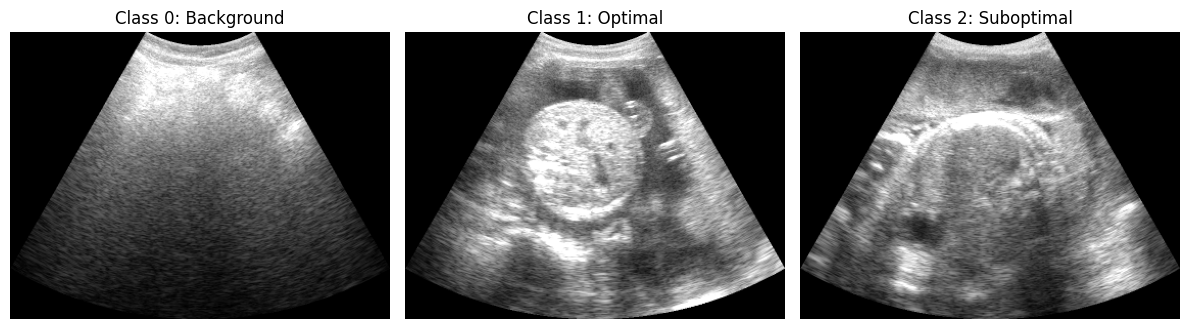

In [4]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# -----------------------------
# Parameters
# -----------------------------
INPUT_DIR = "D:/dataset/npz_80_tiny"

all_counts = Counter()
example_frames = {0: None, 1: None, 2: None}

print("Checking dataset...")

for file in tqdm(sorted(os.listdir(INPUT_DIR))):
    if not file.endswith(".npz"):
        continue
    
    path = os.path.join(INPUT_DIR, file)
    data = np.load(path, allow_pickle=True)

    labels = data["label"]
    images = data["image"]

    # count class distribution
    all_counts.update(labels.tolist())

    # pick first occurrence of each class for visualization
    for c in [0,1,2]:
        if example_frames[c] is None and np.any(labels==c):
            idx = np.where(labels==c)[0][0]
            example_frames[c] = images[idx]

# -----------------------------
# Print global stats
# -----------------------------
total = sum(all_counts.values())
print("\nGlobal class distribution:")
for k in sorted(all_counts.keys()):
    pct = 100*all_counts[k]/total
    print(f"Class {k}: {all_counts[k]} frames ({pct:.2f}%)")

# -----------------------------
# Show example frames
# -----------------------------
fig, axes = plt.subplots(1,3, figsize=(12,4))
titles = {0:"Background", 1:"Optimal", 2:"Suboptimal"}
for i, c in enumerate([0,1,2]):
    if example_frames[c] is not None:
        axes[i].imshow(example_frames[c], cmap="gray", vmin=0, vmax=255)
        axes[i].set_title(f"Class {c}: {titles[c]}")
    else:
        axes[i].text(0.5,0.5,"N/A",ha="center",va="center",fontsize=14)
    axes[i].axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import os, numpy as np
from tqdm import tqdm

INPUT_DIR = "D:/dataset/npz_80_tiny"

print("Inspecting NPZ files...\n")

for i, file in enumerate(sorted(os.listdir(INPUT_DIR))):
    if not file.endswith(".npz"):
        continue

    path = os.path.join(INPUT_DIR, file)
    data = np.load(path, allow_pickle=True)

    print(f"File: {file}")
    print("  Keys:", list(data.keys()))

    # image info
    img = data["image"]
    print(f"  image shape: {img.shape}, dtype={img.dtype}, min={img.min()}, max={img.max()}")

    # labels info
    lbl = data["label"]
    uniq, cnts = np.unique(lbl, return_counts=True)
    print(f"  label shape: {lbl.shape}, dtype={lbl.dtype}, distribution={dict(zip(uniq, cnts))}")

    # optional mask
    if "mask" in data:
        print(f"  mask shape: {data['mask'].shape}, dtype={data['mask'].dtype}")

    # attributes
    print(f"  pixel_spacing: {data['pixel_spacing']}")
    print(f"  ac_reference: {data['ac_reference']}")
    print(f"  uuid: {data['uuid']}")
    if "target_h" in data and "target_w" in data:
        print(f"  resized to: {int(data['target_h'])} x {int(data['target_w'])}")
    if "scale_lo" in data and "scale_hi" in data:
        print(f"  scaling percentiles: lo={float(data['scale_lo'])}, hi={float(data['scale_hi'])}")

    print("-"*50)

    # limit preview
    if i >= 2:  # stop after 3 files for brevity
        break


Inspecting NPZ files...

File: 0199616b-bdeb-4119-97a3-a5a3571bd641.npz
  Keys: ['image', 'label', 'pixel_spacing', 'ac_reference', 'uuid']
  image shape: (80, 281, 372), dtype=uint8, min=0, max=255
  label shape: (80,), dtype=uint8, distribution={np.uint8(0): np.int64(61), np.uint8(2): np.int64(19)}
  pixel_spacing: 0.2800000011920929
  ac_reference: 312.27001953125
  uuid: 0199616b-bdeb-4119-97a3-a5a3571bd641
--------------------------------------------------
File: 02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1.npz
  Keys: ['image', 'label', 'pixel_spacing', 'ac_reference', 'uuid']
  image shape: (80, 281, 372), dtype=uint8, min=0, max=255
  label shape: (80,), dtype=uint8, distribution={np.uint8(0): np.int64(60), np.uint8(2): np.int64(20)}
  pixel_spacing: 0.2800000011920929
  ac_reference: 257.17071533203125
  uuid: 02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1
--------------------------------------------------
File: 02ee26a5-a665-4531-bec1-8bac83345a94.npz
  Keys: ['image', 'label', 'pixel_spacing',

: 